# TP RNN (part. 2)

https://kanoki.org/2020/04/30/time-series-analysis-and-forecasting-with-arima-python/

http://eckner.com/papers/Trend%20and%20Seasonality%20Estimation%20for%20Unevenly%20Spaced%20Time%20Series.pdf

https://coderzcolumn.com/tutorials/data-science/how-to-remove-trend-and-seasonality-from-time-series-data-using-python-pandas


# Imports

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import pandas_datareader.data as data_reader
import statsmodels.api as sm
import statsmodels.tsa as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from keras.utils.vis_utils import plot_model
from keras.models import model_from_json

**For auto-arima**

In [4]:
import pmdarima as pm
from pmdarima import pipeline
from pmdarima import model_selection
from pmdarima import preprocessing as ppc
from pmdarima import arima

In [5]:
import tensorflow as tf

import autokeras as ak

# 1. Data importation & preprocessing

In [6]:
data_train = data_reader.get_data_yahoo("SAN.PA", "3/1/2017", "29/1/2021")['Close']
data_test = data_reader.get_data_yahoo("SAN.PA", "1/2/2021", "26/2/2021")['Close']

In [7]:
data_train.shape

(1001,)

In [8]:
data_test.shape

(40,)

We'll try to work whith log-returns so that, instead of trying to predict $y_{t}$, we'll focus on $r_{t} = \frac{y_{t} - y_{t-1}}{y_{t-1}}$. 

In [9]:
def get_returns(y):
  return diff(y)/y[:-1]

def get_values(r, y0):
  y = zeros(len(r)+1)
  y[0] = y0
  for i in range(len(r)):
    y[i + 1] = y[i] * (1 + r[i])
  return y

In [100]:
y_train = data_train.values
y0_train = y_train[0]
r_train = get_returns(y_train)
assert sum(y_train - get_values(r_train, y0_train)) < 1e-9, "Pb with functions get_returns/get_values"


In [101]:
y_test = data_test.values
tmp_y_test = zeros(len(y_test)+1)
y0_test = y_train[-1]
tmp_y_test[0] = y_train[-1]
tmp_y_test[1:] = y_test
r_test = get_returns(tmp_y_test)
assert sum(y_test - get_values(r_test, y0_test)[1:]) < 1e-9, "Pb with functions get_returns/get_values"

# 2. Univariate distribution & dates feature engineering

## Univariate distribution of returns and values

In [12]:
def plot_time_series(r_train, r_test):

  plot(range(len(r_train)), r_train, c = "b")
  plot(arange(len(r_train), len(r_train)+len(r_test)), r_test, c = 'r')
  legend(["TRAIN", "TEST"])
  title("log-returns")
  xlabel("t")
  show()

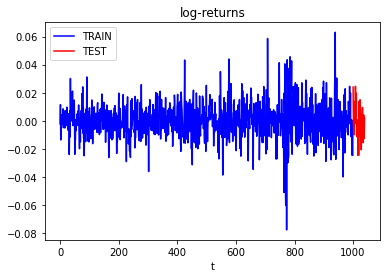

In [13]:
plot_time_series(r_train, r_test)

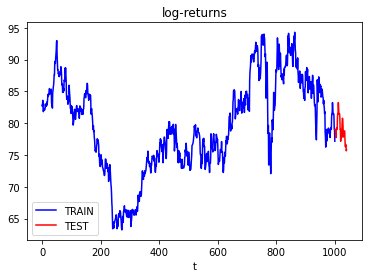

In [14]:
plot_time_series(y_train, y_test)

We removed most of trend by working with returns. With forecasting models we usually prefer to work withoput trend.

## Univariate statistics

In [15]:
df_train = data_train.copy()
df_train = df_train.reset_index()
df_train["returns"] = zeros(len(y_train)) 
df_train["returns"].iloc[1:] = r_train
df_train["values"] = y_train
df_train.head()

C:\Users\louis\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,Close,returns,values
0,2017-03-01,82.820000,0.000000,82.820000
1,2017-03-02,82.639999,-0.002173,82.639999
2,2017-03-03,83.589996,0.011496,83.589996
3,2017-03-06,82.449997,-0.013638,82.449997
4,2017-03-07,81.800003,-0.007883,81.800003


In [16]:
df_test = data_test.copy()
df_test = data_test.reset_index()
df_test["returns"] = r_test
df_test["values"] = y_test
df_test.head()

,Date,Close,returns,values
0,2021-01-04,79.000000,0.023979,79.000000
1,2021-01-05,78.989998,-0.000127,78.989998
2,2021-01-06,78.510002,-0.006077,78.510002
3,2021-01-07,77.720001,-0.010062,77.720001
4,2021-01-08,78.790001,0.013767,78.790001


## Dates feature engineering + pivot date/returns

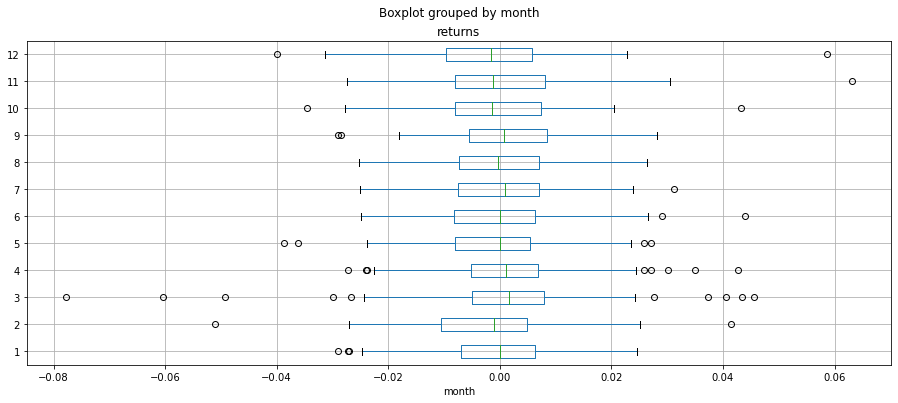

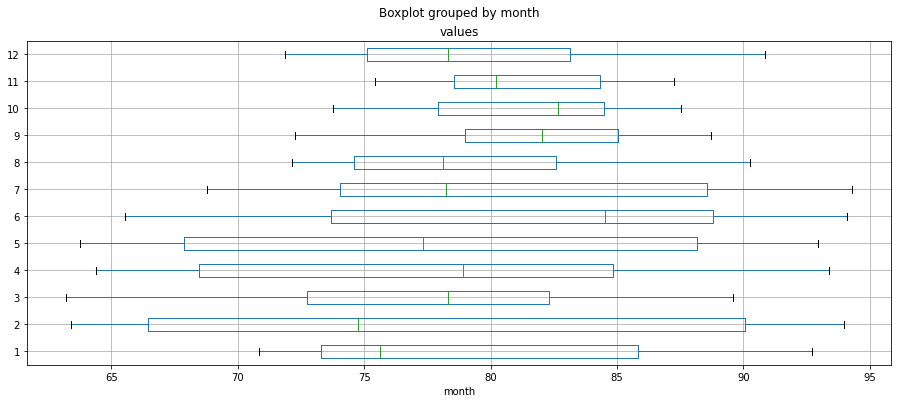

In [17]:
df_train["month"] = pd.DatetimeIndex(df_train['Date']).month
df_test["month"] = pd.DatetimeIndex(df_test['Date']).month
df_train.boxplot(figsize=(15,6), by = "month", column='returns',vert=False)
show()
df_train.boxplot(figsize=(15,6), by = "month", column='values',vert=False)
show()

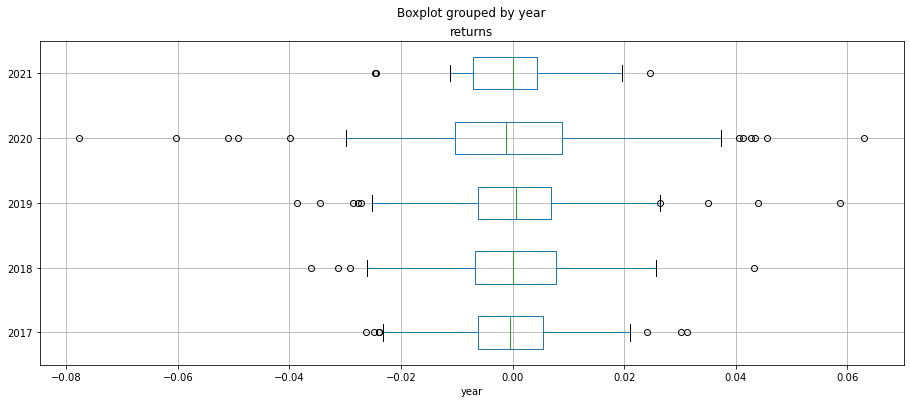

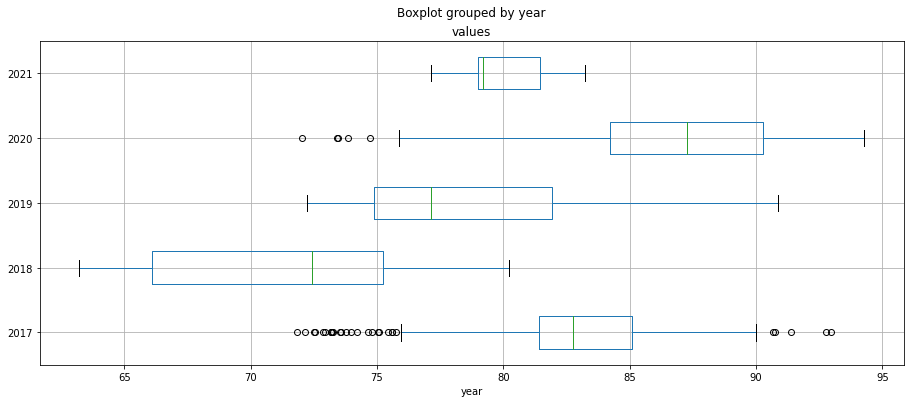

In [18]:
df_train["year"] = pd.DatetimeIndex(df_train['Date']).year
df_test["year"] = pd.DatetimeIndex(df_test['Date']).year
df_train.boxplot(figsize=(15,6), by = "year", column='returns',vert=False)
show()
df_train.boxplot(figsize=(15,6), by = "year", column='values',vert=False)
show()

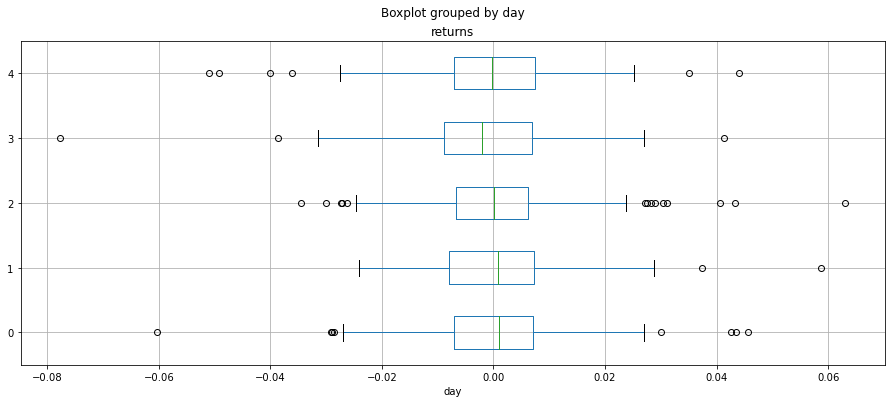

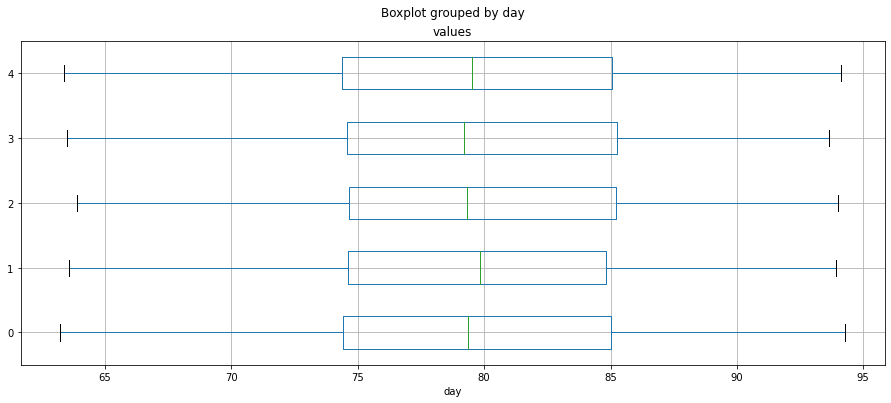

In [19]:
df_train["day"] = pd.DatetimeIndex(df_train['Date']).dayofweek
df_test["day"] = pd.DatetimeIndex(df_test['Date']).dayofweek
df_train.boxplot(figsize=(15,6), by = "day", column='returns',vert=False)
show()
df_train.boxplot(figsize=(15,6), by = "day", column='values',vert=False)
show()

Dates seem to be discriminant on values but not on returns.

## Trend and seasonality Viz

period = month = 30j

<Figure size 1440x1080 with 0 Axes>

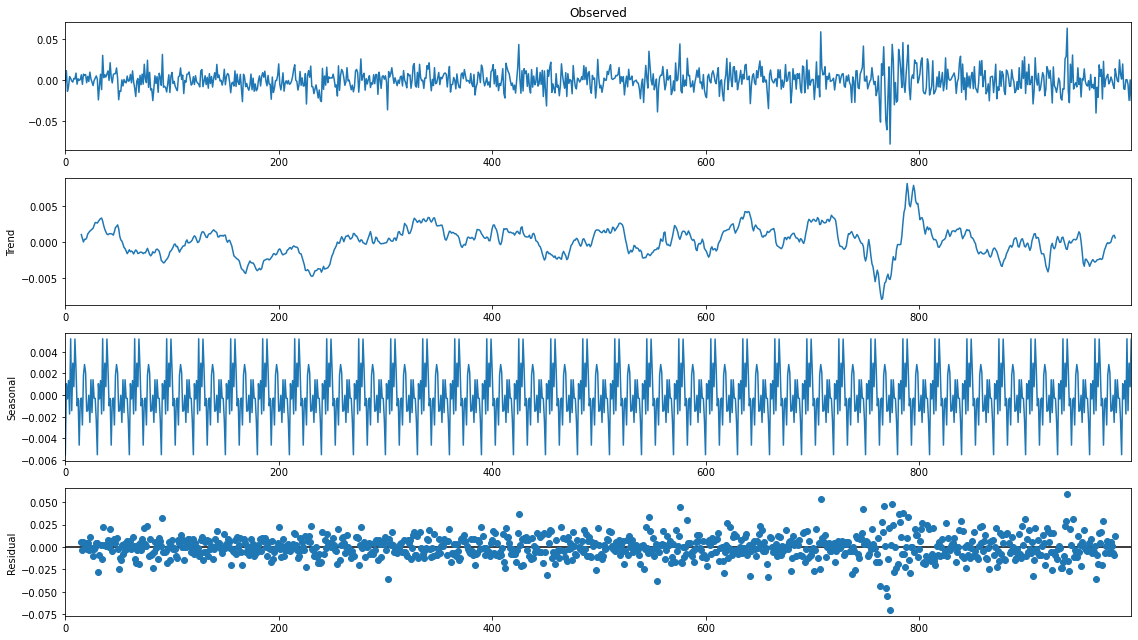

In [20]:
decomposition = sm.tsa.seasonal_decompose(r_train, period = 30, model='additive')
figure(figsize = (20, 15))
rcParams["figure.figsize"] = [16,9]
ax = decomposition.plot()
show(ax)

<Figure size 1440x1080 with 0 Axes>

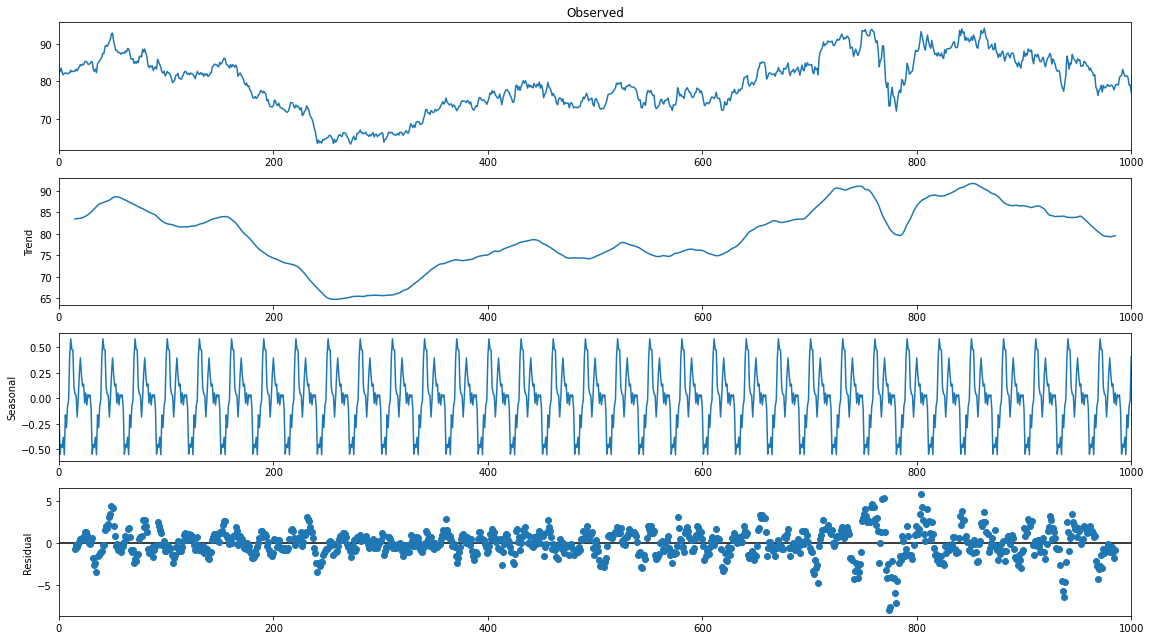

In [21]:
decomposition = sm.tsa.seasonal_decompose(y_train, period = 30, model='additive')
figure(figsize = (20, 15))
rcParams["figure.figsize"] = [16,9]
ax = decomposition.plot()
show(ax)

The seasonnality seems more regular with values, but trend & noise are less regular... Until now it is impossible to choose a target with good properties for forecasting.

## Stationarity?

Augmented Dickey-Fuller test

H0 : there is a unit root

In [22]:
def check_stationarity(r):

    result = tsa.stattools.adfuller(r, regression = "ctt", autolag='AIC') #He'll determine lag by itself!

    dfoutput = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print('The test statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')

    for key, value in result[4].items():
        print('%s: %.3f' % (key, value))

In [23]:
check_stationarity(r_train)

The test statistic: -22.880750
p-value: 0.000000
Critical Values:
1%: -4.383
5%: -3.838
10%: -3.557


In [24]:
check_stationarity(y_train)

The test statistic: -2.237501
p-value: 0.711581
Critical Values:
1%: -4.383
5%: -3.838
10%: -3.557


**returns**

p-value ~ 0, we reject H0, that is we can reject that there is a unit root in data. So, it tells us that data is stationary!

**values**

p-value > 0, we cannot reject H0, that is "there is a unit root in data";

ARMA is good with stationnary data, SARIMA likes un-stationary data...

## Auto-correlation & Partial auto correlation plots

Remark : we'll perform an ARIMA (p,d,q). The hyperparameters p & q will be determined with auto-ML but just to give interpretability and prior for auto-ML, let's determine optimal p & q with a graphical method.

<Figure size 1440x1080 with 0 Axes>

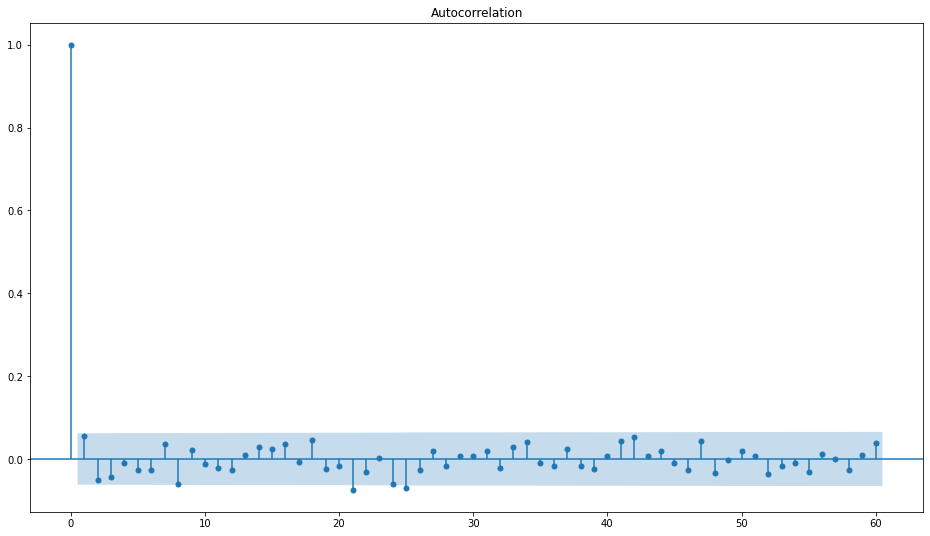

In [25]:
figure(figsize = (20, 15))
ax = plot_acf(r_train,lags=60)
show(ax)

Target seems uncorrelated to any of its previous values. So that if we had to choose q according to this plot, q would be equal to 0. 

<Figure size 1440x1080 with 0 Axes>

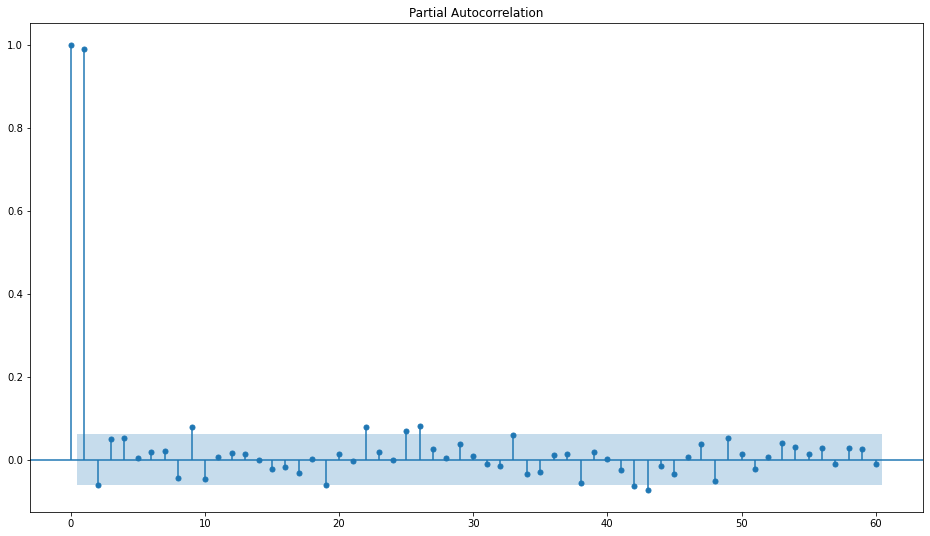

In [26]:
figure(figsize = (20, 15))
ax = plot_pacf(y_train,lags=60)
show(ax)

### Lag for returns

p = 0. That means we shouldn't use lag for ARIMA. In other words, there is no (linear) correlation in our time series. 

**rk**: NN are able to capture non-linear relationships.

**Conclusion**

Our prior (p,d,q) would be (0,0,0)... (we deduced d value with the stationnarity test).

### Lag for values

p=1. It seems that data is correlated to its past (it is a markovian process). It is possible that with a SARIMA, we could do better that just estimate by the average. 

# 3. Usual Forecasting (without features)

## 3.1 Auto-SARIMA on returns

In [27]:
auto_arima = pm.auto_arima(r_train, 
                           m = 1, #Let's suppose we got a weekly periodicity
                           start_p=0, 
                           start_q=0,
                           max_p=60,
                           max_q=60,
                           max_Q = 60,
                           max_P = 60,
                           trend = 'ctt',
                           seasonal = True,
                           trace = True)
                        

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-5865.026, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-5866.054, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-5866.384, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-5865.026, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-5864.911, Time=0.28 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-5866.728, Time=0.29 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-5861.521, Time=0.33 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-5866.909, Time=0.33 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-5864.958, Time=0.38 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=-5864.893, Time=0.39 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=-5863.042, Time=0.44 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-5866.909, Time=0.33 sec

Best model:  ARIMA(0,0,3)(0,0,0)[0] intercept
Total fit time: 3.504 seconds


In [28]:
arima_predictions, arima_ic = auto_arima.predict_in_sample(start = 0, end = len(r_test) + len(r_train) - 1, return_conf_int=True)
r_pred_train = arima_predictions[:len(r_train)]
r_pred = arima_predictions[len(r_train):]
ic_train = arima_ic[:len(r_train),:]
ic_test = arima_ic[len(r_train):,:]

In [29]:
ic_train.shape

(1000, 2)

### Assessment

Text(0.5, 1.0, 'TEST Assessment of ARIMA forecasting')

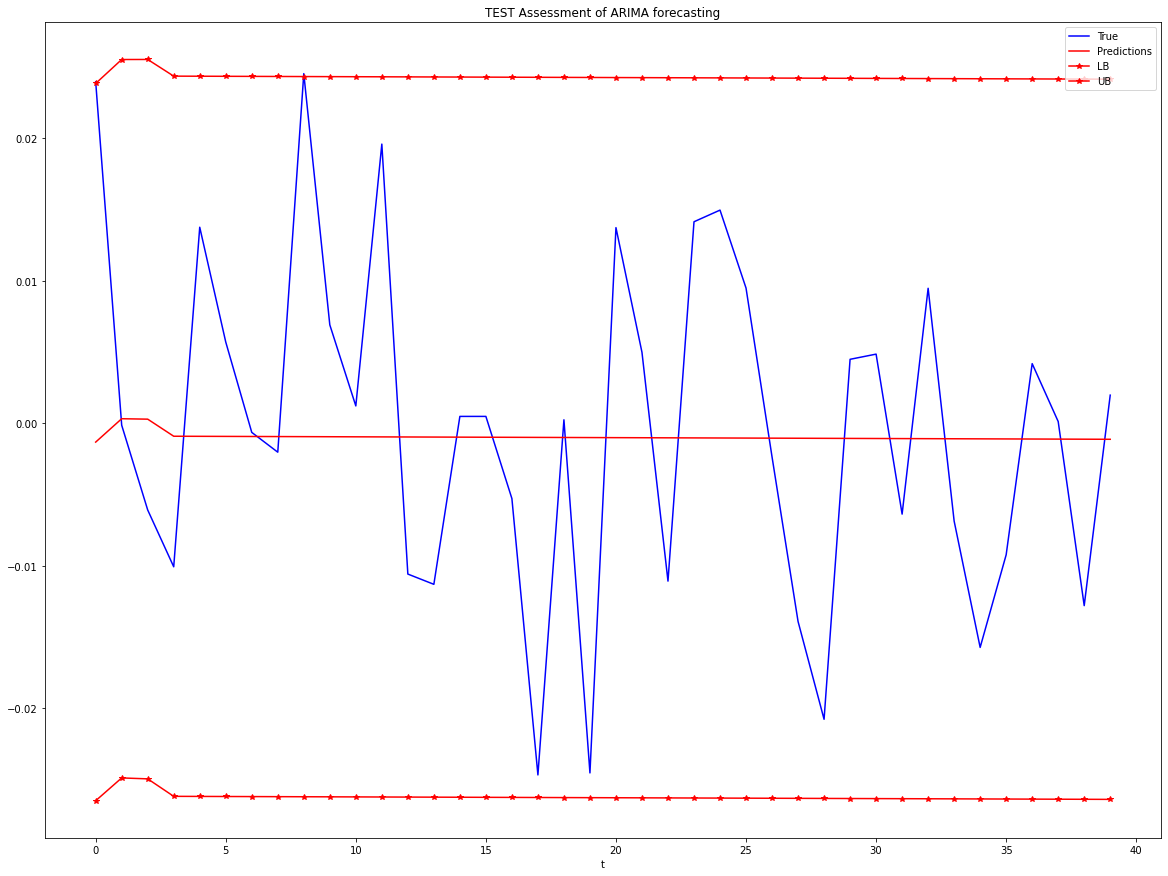

In [30]:
figure(figsize = (20, 15))
plot(range(len(r_test)), r_test, c = 'b')
plot(range(len(r_test)), r_pred, c = 'r')
plot(range(len(r_test)), ic_test[:,0], c = 'r', marker = "*")
plot(range(len(r_test)), ic_test[:,1], c = 'r', marker = "*")
legend(["True", "Predictions", 'LB', 'UB'])
xlabel("t")
title("TEST Assessment of ARIMA forecasting")

Text(0.5, 1.0, 'TRAIN Assessment of ARIMA forecasting')

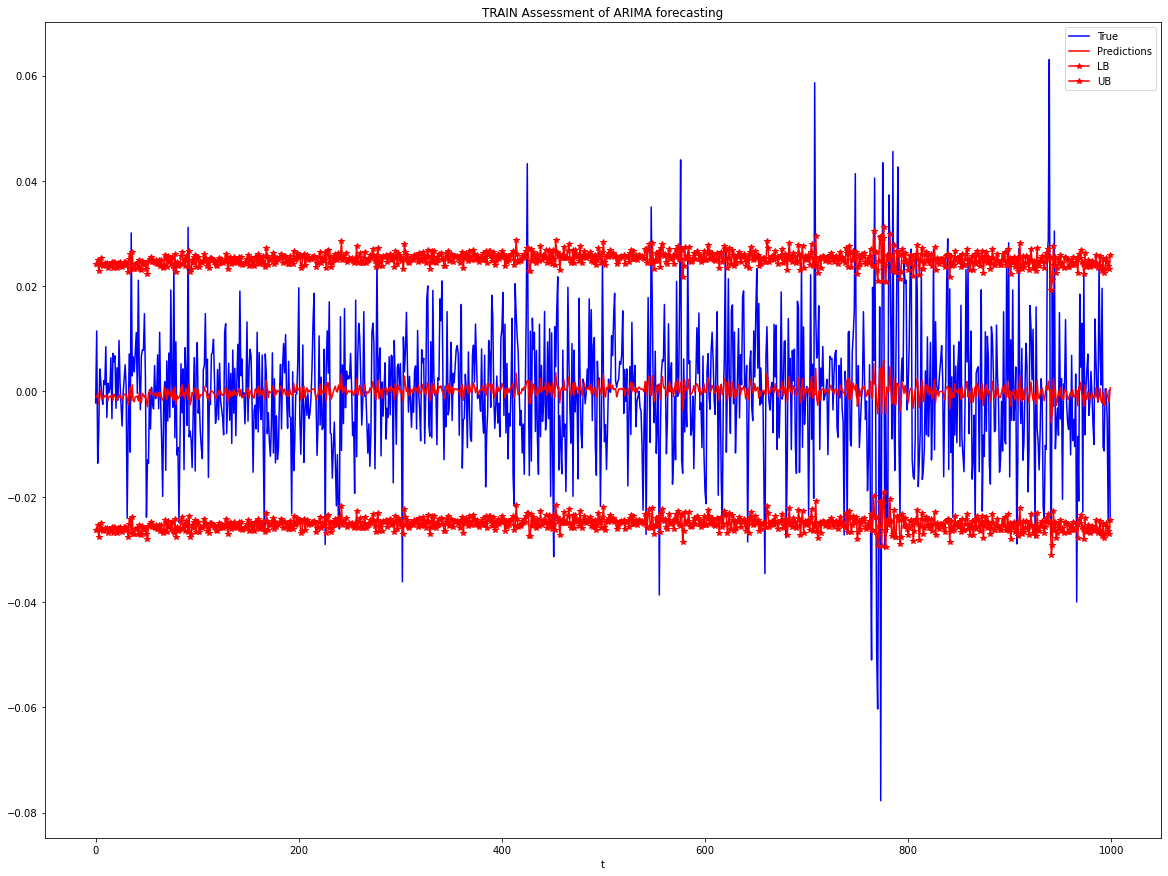

In [31]:
figure(figsize = (20, 15))
plot(range(len(r_train)), r_train, c = 'b')
plot(range(len(r_train)), r_pred_train, c = 'r')
plot(range(len(r_train)), ic_train[:,0], c = 'r', marker = "*")
plot(range(len(r_train)), ic_train[:,1], c = 'r', marker = "*")
legend(["True", "Predictions", 'LB', 'UB'])
xlabel("t")
title("TRAIN Assessment of ARIMA forecasting")

We almost estimate everything by the mean... It's also what did thhe first NN.

In [32]:
print(auto_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(0, 0, 3)   Log Likelihood                2940.454
Date:                Sun, 23 May 2021   AIC                          -5866.909
Time:                        11:18:38   BIC                          -5832.554
Sample:                             0   HQIC                         -5853.852
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0010      0.002     -0.688      0.491      -0.004       0.002
drift       5.996e-06   6.27e-06      0.956      0.339    -6.3e-06    1.83e-05
trend.2    -5.844e-09   5.78e-09     -1.012      0.3

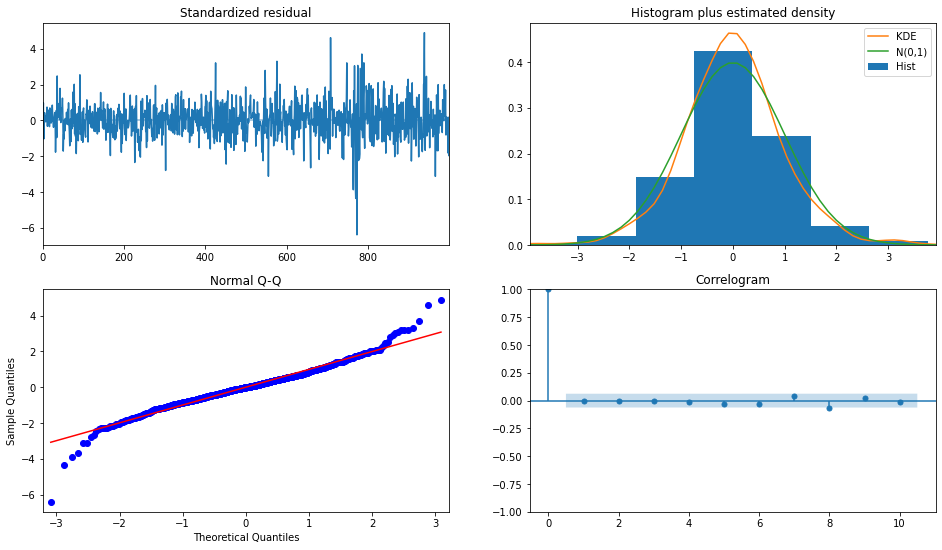

In [33]:
ax = auto_arima.plot_diagnostics()
show(ax)

In [34]:
y_pred = get_values(r_pred, y0_test)[1:]

print("##########R2########")
print(r2_score(y_pred, y_test))
print("########MSE#########")
print(mean_squared_error(y_pred, y_test))
print("######RMSE########")
print(sqrt(mean_squared_error(y_pred, y_test)))

##########R2########
-16.326585603251054
########MSE#########
12.96912564975609
######RMSE########
3.6012672283178446


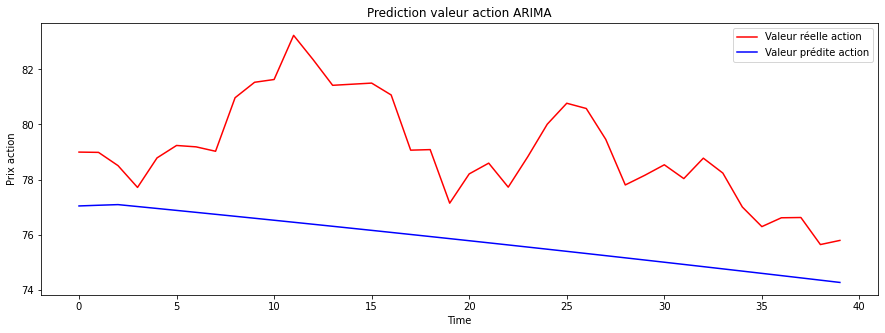

In [35]:
figure(figsize=(15,5))
plot(y_test, color = 'red', label = 'Valeur réelle action')
plot(y_pred, color = 'blue', label = 'Valeur prédite action')
title('Prediction valeur action ARIMA')
xlabel('Time')
ylabel('Prix action')
legend()
show()

SARIMA did really better than LSTM!

The question is : could we use the output of SARIMA for our LSTM ? I think not because it has been bad for predicting future values. And the problem of flat predictions would have much influence on NN with high risks of overfitting!

Nonetheless, the ARIMA model tells us relevent things :

- data seems seasonal

- data is stationary

- Lag is not relevent in a linear sense.

- data is not gaussian : what about log-returns?

## 3.2 SARIMA on values

In [36]:
auto_arima = pm.auto_arima(y_train, 
                           m = 1, #Let's suppose we got a weekly periodicity
                           start_p=0, 
                           start_q=0,
                           max_p=60,
                           max_q=60,
                           max_Q = 60,
                           max_P = 60,
                           trend = 'ctt',
                           seasonal = True,
                           trace = True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2918.424, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2917.431, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2917.116, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2918.424, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2918.875, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2916.951, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2920.563, Time=0.34 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2916.126, Time=0.35 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2918.107, Time=0.39 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=2918.176, Time=0.40 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=2919.573, Time=1.03 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=2916.126, Time=0.35 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0]          
Total fit time: 4.330 seconds


In [37]:
arima_predictions, arima_ic = auto_arima.predict_in_sample(start = 1, end = len(y_test) + len(y_train) - 1, return_conf_int=True)
y_pred_train = arima_predictions[:len(y_train) - 1]
y_pred = arima_predictions[len(y_train) - 1:]
ic_train = arima_ic[:len(y_train) - 1,:]
ic_test = arima_ic[len(y_train) - 1:,:]

### Assessment

Text(0.5, 1.0, 'TEST Assessment of ARIMA forecasting')

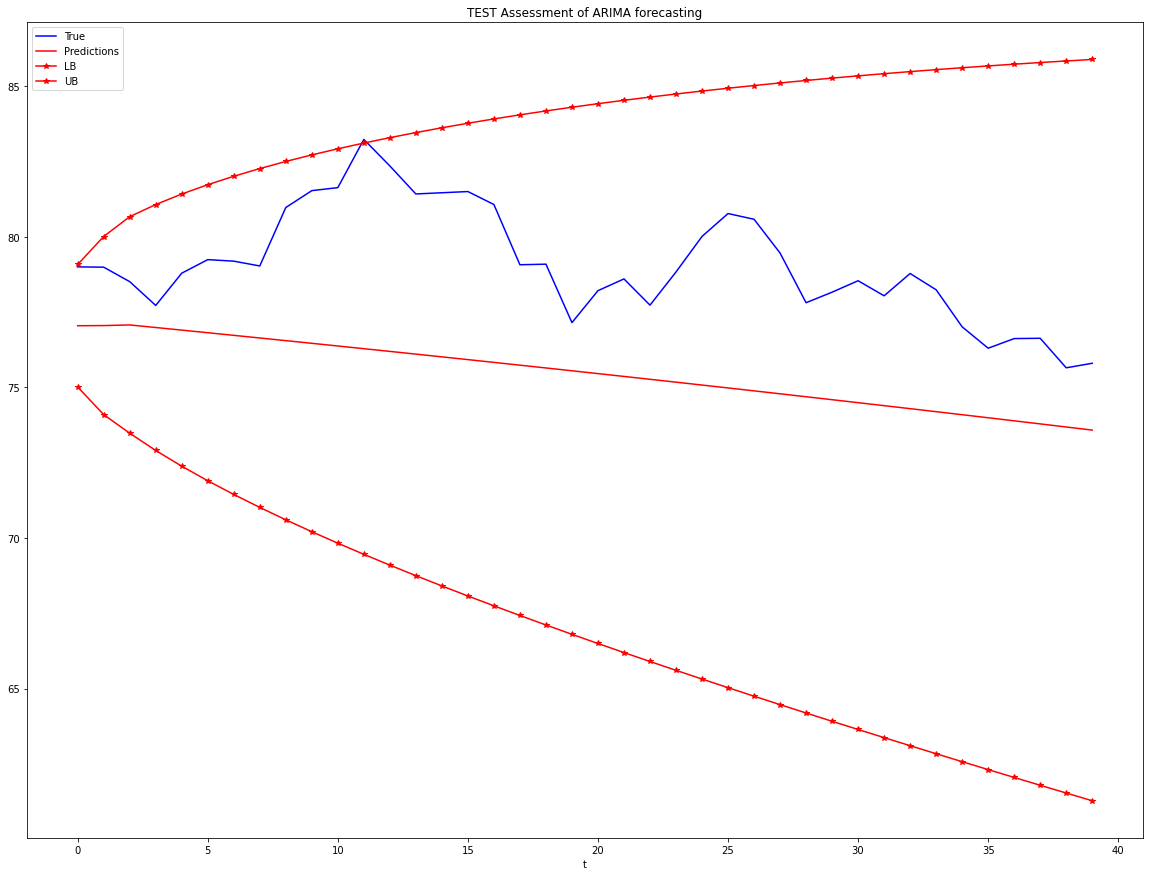

In [38]:
figure(figsize = (20, 15))
plot(range(len(y_test)), y_test, c = 'b')
plot(range(len(y_test)), y_pred, c = 'r')
plot(range(len(y_test)), ic_test[:,0], c = 'r', marker = "*")
plot(range(len(y_test)), ic_test[:,1], c = 'r', marker = "*")
legend(["True", "Predictions", 'LB', 'UB'])
xlabel("t")
title("TEST Assessment of ARIMA forecasting")

Text(0.5, 1.0, 'TRAIN Assessment of ARIMA forecasting')

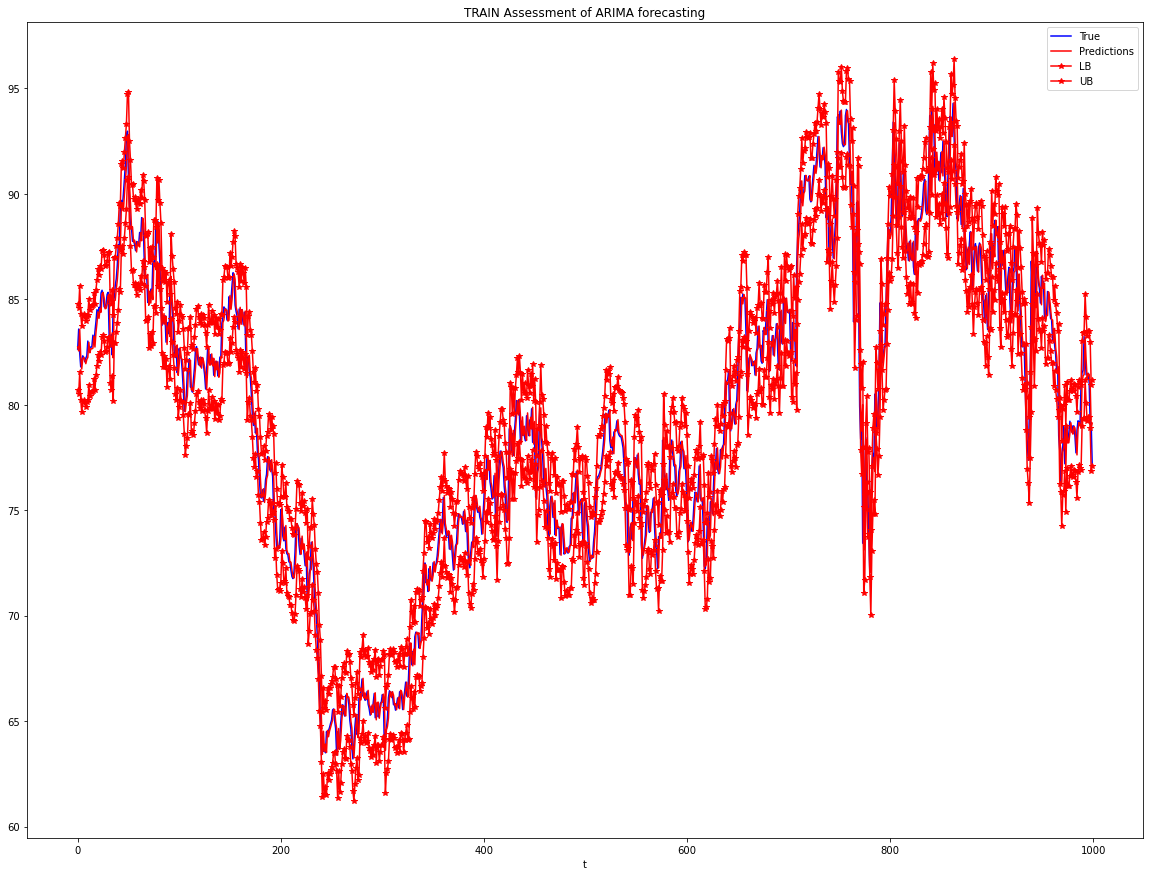

In [39]:
figure(figsize = (20, 15))
plot(range(len(y_train) - 1), y_train[1:], c = 'b')
plot(range(len(y_train) - 1), y_pred_train, c = 'r')
plot(range(len(y_train) - 1), ic_train[:,0], c = 'r', marker = "*")
plot(range(len(y_train) - 1), ic_train[:,1], c = 'r', marker = "*")
legend(["True", "Predictions", 'LB', 'UB'])
xlabel("t")
title("TRAIN Assessment of ARIMA forecasting")

In [40]:
print(auto_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1001
Model:               SARIMAX(0, 1, 3)   Log Likelihood               -1451.063
Date:                Sun, 23 May 2021   AIC                           2916.126
Time:                        11:18:44   BIC                           2950.481
Sample:                             0   HQIC                          2929.183
                               - 1001                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0825      0.118     -0.697      0.486      -0.315       0.150
drift          0.0005      0.001      0.925      0.355      -0.001       0.001
trend.2    -4.639e-07   4.64e-07     -0.999      0.3

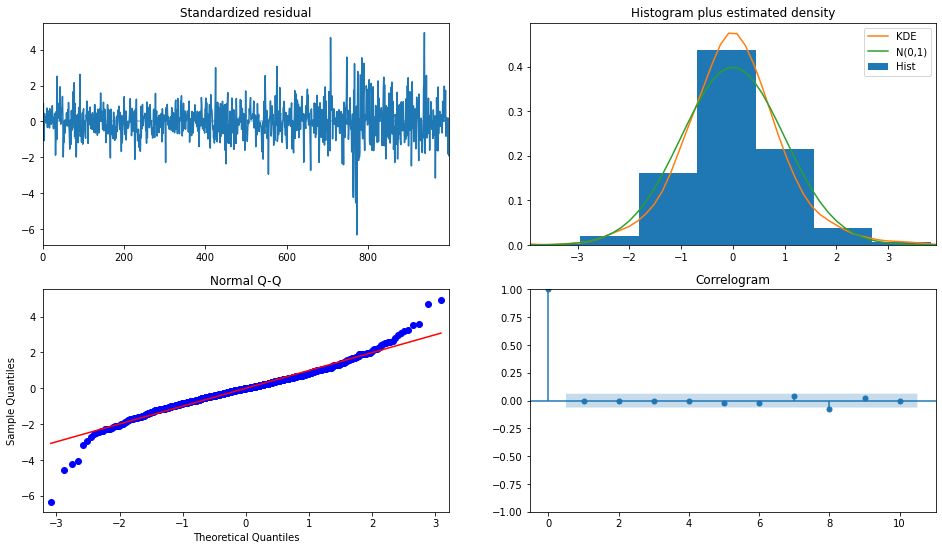

In [41]:
ax = auto_arima.plot_diagnostics()
show(ax)

In [42]:
y_pred = get_values(r_pred, y0_test)[1:]

print("##########R2########")
print(r2_score(y_pred, y_test))
print("########MSE#########")
print(mean_squared_error(y_pred, y_test))
print("######RMSE########")
print(sqrt(mean_squared_error(y_pred, y_test)))

##########R2########
-16.326585603251054
########MSE#########
12.96912564975609
######RMSE########
3.6012672283178446


We should work with values!

The best model we got until now is this one

# 4. Adding features

https://www.investing.com/search/?q=CAC40

We'll use as additional features :

- Euribor market curve data

- Asset market volatility

- Time components (we already got categorical information from dates).

For 1 & 2 we got at any time market anticipations, which has an influence on its true values, that we may use to replace true values.

We can't use "Volume" because it is unrealistic to anticipate its value without knowing 'Close' value.

## External Data

### Euribor

In [43]:
def K_formatting(S):
    
    try :
        splitted_S = S.split('K')
        value = float(splitted_S[0])
        return value * 1000
    except :
        print(S)
        return NaN

#test
K_formatting("57.0K")

57000.0

In [44]:
euribor = pd.read_csv("https://raw.githubusercontent.com/louis75020/Deep_learning_M2/TP_RNN/Euribor%20Futures%20Historical%20Data.csv",
                      header = 0,
                      names = ["Date", "EUR_Price","Open","High","Low","EUR_Vol","Change %"])
euribor["Date"] = pd.to_datetime(euribor["Date"])

In [45]:
df_train2 = pd.merge(df_train, euribor[['EUR_Price', 'Date', 'EUR_Vol']], how = "left", on = 'Date')
df_train2["EUR_Vol"] = list(map(K_formatting, df_train2["EUR_Vol"]))
df_test2 = pd.merge(df_test, euribor[['EUR_Price', 'Date', 'EUR_Vol']], how = "left", on = 'Date')
df_test2["EUR_Vol"] = list(map(K_formatting, df_test2["EUR_Vol"]))

-
-
-
-
nan


In [46]:
df_train2

,Date,Close,returns,values,month,year,day,EUR_Price,EUR_Vol
0,2017-03-01,82.820000,0.000000,82.820000,3,2017,2,100.32,57130.0
1,2017-03-02,82.639999,-0.002173,82.639999,3,2017,3,100.32,60530.0
2,2017-03-03,83.589996,0.011496,83.589996,3,2017,4,100.32,59450.0
3,2017-03-06,82.449997,-0.013638,82.449997,3,2017,0,100.32,33440.0
4,2017-03-07,81.800003,-0.007883,81.800003,3,2017,1,100.33,44370.0
...,...,...,...,...,...,...,...,...,...
996,2021-01-25,81.500000,0.000491,81.500000,1,2021,0,100.54,8780.0
997,2021-01-26,81.070000,-0.005276,81.070000,1,2021,1,100.54,2940.0
998,2021-01-27,79.070000,-0.024670,79.070000,1,2021,2,100.55,37260.0
999,2021-01-28,79.089996,0.000253,79.089996,1,2021,3,100.55,15270.0


### CAC40

In [47]:
def M_formatting(S):
    
    try :
        splitted_S = S.split('M')
        value = float(splitted_S[0])
        return value * 1000000
    except :
        print(S)
        return NaN

#test
M_formatting("57.0M")

57000000.0

In [48]:
def coma_formatting(S):
    
    try :
        S_woComas = ''
        for s in S.split(','): S_woComas += s
        return float(S_woComas)
    except :
        print(S)
        return NaN
    
#test
coma_formatting("4,960.83")

4960.83

In [49]:
cac40 = pd.read_csv("https://raw.githubusercontent.com/louis75020/Deep_learning_M2/TP_RNN/CAC%2040%20Historical%20Data.csv",
                    header = 0,
                    names = ["Date","CAC_Price","Open","High","Low","CAC_Vol","Change %"])

In [50]:
cac40["Date"] = pd.to_datetime(cac40["Date"])
df_train2 = pd.merge(df_train2, cac40[['CAC_Price', 'Date', 'CAC_Vol']], on = 'Date', how = "left")
df_train2["CAC_Vol"] = list(map(M_formatting, df_train2["CAC_Vol"]))
df_train2["CAC_Price"] = list(map(coma_formatting, df_train2["CAC_Price"]))
df_test2 = pd.merge(df_test2, cac40[['CAC_Price', 'Date', 'CAC_Vol']], on = 'Date', how = "left")
df_test2["CAC_Vol"] = list(map(M_formatting, df_test2["CAC_Vol"]))
df_test2["CAC_Price"] = list(map(coma_formatting, df_test2["CAC_Price"]))

nan
nan


In [51]:
df_train2

,Date,Close,returns,values,month,year,day,EUR_Price,EUR_Vol,CAC_Price,CAC_Vol
0,2017-03-01,82.820000,0.000000,82.820000,3,2017,2,100.32,57130.0,4960.83,123970000.0
1,2017-03-02,82.639999,-0.002173,82.639999,3,2017,3,100.32,60530.0,4963.80,110140000.0
2,2017-03-03,83.589996,0.011496,83.589996,3,2017,4,100.32,59450.0,4995.13,108600000.0
3,2017-03-06,82.449997,-0.013638,82.449997,3,2017,0,100.32,33440.0,4972.19,93220000.0
4,2017-03-07,81.800003,-0.007883,81.800003,3,2017,1,100.33,44370.0,4955.00,82300000.0
...,...,...,...,...,...,...,...,...,...,...,...
996,2021-01-25,81.500000,0.000491,81.500000,1,2021,0,100.54,8780.0,5472.36,103150000.0
997,2021-01-26,81.070000,-0.005276,81.070000,1,2021,1,100.54,2940.0,5523.52,84020000.0
998,2021-01-27,79.070000,-0.024670,79.070000,1,2021,2,100.55,37260.0,5459.62,123360000.0
999,2021-01-28,79.089996,0.000253,79.089996,1,2021,3,100.55,15270.0,5510.52,113180000.0


## Periodical signals

In [52]:
dummies = pd.get_dummies(df_train2, columns = ['day', 'year','month'])
df_train2[list(dummies.columns)] = dummies
dummies = pd.get_dummies(df_test2, columns = ['day', 'year','month'])
df_test2[list(dummies.columns)] = dummies

for x in list(df_test2.columns):
    if not x in list(df_train2.columns):
      del df_test2[x]
  
for x in list(df_train2.columns) :
  if not x in list(df_test.columns):
    df_test2[x] = zeros(df_test2.shape[0])

In [53]:
df_train2.shape

(1001, 33)

In [54]:
df_test2.shape

(40, 33)

### check

In [55]:
df_train2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1001 entries, 0 to 1000
Data columns (total 33 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1001 non-null   datetime64[ns]
 1   Close      1001 non-null   float64       
 2   returns    1001 non-null   float64       
 3   values     1001 non-null   float64       
 4   month      1001 non-null   int64         
 5   year       1001 non-null   int64         
 6   day        1001 non-null   int64         
 7   EUR_Price  1000 non-null   float64       
 8   EUR_Vol    996 non-null    float64       
 9   CAC_Price  1000 non-null   float64       
 10  CAC_Vol    1000 non-null   float64       
 11  day_0      1001 non-null   uint8         
 12  day_1      1001 non-null   uint8         
 13  day_2      1001 non-null   uint8         
 14  day_3      1001 non-null   uint8         
 15  day_4      1001 non-null   uint8         
 16  year_2017  1001 non-null   uint8         


## X_train, X_test

We' ll build 2 data sets :

- without_cheat : lag 1 + dates

- with_cheat : lag 1 + dates + features

We 'll build a true forecasting realistic model with data set without_cheat and an efficient but unrealistic model with the second.

In [102]:
X_train = df_train2.drop(["Date", 
                         "Close",
                         "returns",
                         "values",
                         "month",
                         "year",
                         "day",
                         "EUR_Price",
                         "EUR_Vol",
                         "CAC_Price",
                         "CAC_Vol"], axis = 1)

X_test = df_test2.drop( ["Date", 
                         "Close",
                         "returns",
                         "values",
                         "month",
                         "year",
                         "day",
                         "EUR_Price",
                         "EUR_Vol",
                         "CAC_Price",
                         "CAC_Vol"], axis = 1)

X_train_wc = df_train2.drop(["Date", 
                             "Close",
                             "returns",
                             "values",
                             "month",
                             "year",
                             "day"], axis = 1)

X_test_wc = df_test2.drop(["Date", 
                         "Close",
                         "returns",
                         "values",
                         "month",
                         "year",
                         "day"], axis = 1)

### lag 1

In [103]:
X_train = X_train.iloc[1:]
X_train.loc[:,'lag1'] = y_train[:-1]

X_train_wc = X_train_wc.iloc[1:]
X_train_wc.loc[:,'lag1'] = y_train[:-1]

In [104]:
X_test.loc[1:,'lag1'] = y_test[:-1]
X_test.loc[0, 'lag1'] = y_train[-1]

X_test_wc.loc[1:,'lag1'] = y_test[:-1]
X_test_wc.loc[0, 'lag1'] = y_train[-1]

### Missing values

In [105]:
imputer = IterativeImputer()

imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

imputer.fit(X_train_wc)
X_train_wc = imputer.transform(X_train_wc)
X_test_wc = imputer.transform(X_test_wc)

### Standard Scaler

In [106]:
scaler = StandardScaler() 

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

scaler.fit(X_train_wc)
X_train_wc = scaler.transform(X_train_wc)
X_test_wc = scaler.transform(X_test_wc)

### Validation dataset

In [107]:
X_val = X_train[-40:,:]
X_train = X_train[:-40, :]

X_val_wc = X_train_wc[-40:, :]
X_train_wc = X_train_wc[:-40, :]

In [108]:
y_val = y_train[-40:]
y_train = y_train[:-40]

In [63]:
X_train.shape

(960, 23)

In [64]:
X_val.shape

(40, 23)

In [65]:
X_test.shape

(40, 23)

# Modelization

Remark :
- In part. 1 we tried a prior neural network and a neural network with prior on hyperparameters (and a CV to choose these).
- It failed.
- We have seen in part.2 that a classical forecasting model (SARIMA) had worked.
- We'll try a true auto-ML package (based on keras tuner but which does not require to specify hyperparameters sets).

## Without cheat

In [68]:
lookback = 1

clf = ak.TimeseriesForecaster(lookback=lookback,
                              max_trials=50,
                              objective="val_loss")

# Train the TimeSeriesForecaster with train data
clf.fit(x=X_train,
        y=y_train,
        validation_data=(X_val, y_val),
        batch_size=32,
        epochs=30)

Trial 33 Complete [00h 00m 12s]
val_loss: 3444.218017578125

Best val_loss So Far: 2.8031163215637207
Total elapsed time: 00h 07m 04s
INFO:tensorflow:Oracle triggered exit
Epoch 1/30
30/30 [==============================] - 2s 16ms/step - loss: 3675.2280 - mean_squared_error: 3675.2280 - val_loss: 1483.4988 - val_mean_squared_error: 1483.4988
Epoch 2/30
30/30 [==============================] - 0s 5ms/step - loss: 850.6034 - mean_squared_error: 850.6034 - val_loss: 302.5730 - val_mean_squared_error: 302.5730
Epoch 3/30
30/30 [==============================] - 0s 5ms/step - loss: 284.0966 - mean_squared_error: 284.0966 - val_loss: 68.1434 - val_mean_squared_error: 68.1434
Epoch 4/30
30/30 [==============================] - 0s 5ms/step - loss: 169.6324 - mean_squared_error: 169.6324 - val_loss: 16.8773 - val_mean_squared_error: 16.8773
Epoch 5/30
30/30 [==============================] - 0s 5ms/step - loss: 144.3059 - mean_squared_error: 144.3059 - val_loss: 7.9650 - val_mean_squared_error

INFO:tensorflow:Assets written to: .\time_series_forecaster\best_model\assets


INFO:tensorflow:Assets written to: .\time_series_forecaster\best_model\assets


In [72]:
model = clf.export_model()

In [79]:
full_train = concatenate((X_train, X_val)).reshape(-1,1,23)
full_train.shape

(1000, 1, 23)

In [83]:
full_y = concatenate((y_train[1:],y_val))

In [85]:
model.fit(x = full_train, y = full_y, epochs = 300, batch_size = 32)

Epoch 1/300
32/32 [==============================] - 0s 997us/step - loss: 193.6604 - mean_squared_error: 193.6604
Epoch 2/300
32/32 [==============================] - 0s 935us/step - loss: 88.5864 - mean_squared_error: 88.5864
Epoch 3/300
32/32 [==============================] - 0s 901us/step - loss: 78.6390 - mean_squared_error: 78.6390
Epoch 4/300
32/32 [==============================] - 0s 1ms/step - loss: 76.2713 - mean_squared_error: 76.2713
Epoch 5/300
32/32 [==============================] - 0s 901us/step - loss: 86.9049 - mean_squared_error: 86.9049
Epoch 6/300
32/32 [==============================] - 0s 1ms/step - loss: 80.1731 - mean_squared_error: 80.1731
Epoch 7/300
32/32 [==============================] - 0s 975us/step - loss: 82.4133 - mean_squared_error: 82.4133
Epoch 8/300
32/32 [==============================] - 0s 1ms/step - loss: 76.7827 - mean_squared_error: 76.7827
Epoch 9/300
32/32 [==============================] - 0s 902us/step - loss: 77.0854 - mean_squared_er

32/32 [==============================] - 0s 923us/step - loss: 62.7731 - mean_squared_error: 62.7731
Epoch 74/300
32/32 [==============================] - 0s 885us/step - loss: 60.8479 - mean_squared_error: 60.8479
Epoch 75/300
32/32 [==============================] - 0s 916us/step - loss: 65.9059 - mean_squared_error: 65.9059
Epoch 76/300
32/32 [==============================] - 0s 869us/step - loss: 56.4619 - mean_squared_error: 56.4619
Epoch 77/300
32/32 [==============================] - 0s 916us/step - loss: 62.8987 - mean_squared_error: 62.8987
Epoch 78/300
32/32 [==============================] - 0s 901us/step - loss: 64.7040 - mean_squared_error: 64.7040
Epoch 79/300
32/32 [==============================] - 0s 918us/step - loss: 61.6999 - mean_squared_error: 61.6999
Epoch 80/300
32/32 [==============================] - 0s 836us/step - loss: 58.4158 - mean_squared_error: 58.4158
Epoch 81/300
32/32 [==============================] - 0s 870us/step - loss: 56.7743 - mean_squared_er

32/32 [==============================] - 0s 882us/step - loss: 46.3846 - mean_squared_error: 46.3846
Epoch 215/300
32/32 [==============================] - 0s 900us/step - loss: 44.9936 - mean_squared_error: 44.9936
Epoch 216/300
32/32 [==============================] - 0s 930us/step - loss: 44.6668 - mean_squared_error: 44.6668
Epoch 217/300
32/32 [==============================] - 0s 913us/step - loss: 46.4696 - mean_squared_error: 46.4696
Epoch 218/300
32/32 [==============================] - 0s 895us/step - loss: 46.3143 - mean_squared_error: 46.3143
Epoch 219/300
32/32 [==============================] - 0s 883us/step - loss: 42.0803 - mean_squared_error: 42.0803
Epoch 220/300
32/32 [==============================] - 0s 897us/step - loss: 44.6030 - mean_squared_error: 44.6030
Epoch 221/300
32/32 [==============================] - 0s 877us/step - loss: 45.6287 - mean_squared_error: 45.6287
Epoch 222/300
32/32 [==============================] - 0s 939us/step - loss: 46.0325 - mean_sq

In [86]:
model_json = model.to_json()
with open("trained_model_rnn_pt2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_rnn_pt2.weights")
print("Saved model to disk")

Saved model to disk


In [87]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 23)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 23)                4324      
_________________________________________________________________
dropout (Dropout)            (None, 23)                0         
_________________________________________________________________
regression_head_1 (Dense)    (None, 1)                 24        
Total params: 4,348
Trainable params: 4,348
Non-trainable params: 0
_________________________________________________________________


In [88]:
predictions = model.predict(X_test.reshape(-1,1,23))[:,0]
predictions.shape

(40,)

In [89]:
print("##########R2########")
print(r2_score(predictions, y_test))
print("########MSE#########")
print(mean_squared_error(predictions, y_test))
print("######RMSE########")
print(sqrt(mean_squared_error(predictions, y_test)))

##########R2########
-1049.1006963696013
########MSE#########
1172.2720807262951
######RMSE########
34.23845908808244


## With cheat

In [109]:
lookback = 1

clf2 = ak.TimeseriesForecaster(lookback=lookback,
                              max_trials=50,
                              objective="val_loss")

# Train the TimeSeriesForecaster with train data
clf2.fit(x=X_train_wc,
        y=y_train,
        validation_data=(X_val_wc, y_val),
        batch_size=32,
        epochs=30)

Trial 15 Complete [00h 00m 14s]
val_loss: 4.517632484436035

Best val_loss So Far: 3.583308458328247
Total elapsed time: 00h 03m 43s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/30
30/30 [==============================] - 6s 55ms/step - loss: 1572.0941 - mean_squared_error: 1572.0941 - val_loss: 94.3889 - val_mean_squared_error: 94.3889
Epoch 2/30
30/30 [==============================] - 0s 6ms/step - loss: 203.8198 - mean_squared_error: 203.8198 - val_loss: 11.7661 - val_mean_squared_error: 11.7661
Epoch 3/30
30/30 [==============================] - 0s 6ms/step - loss: 82.3275 - mean_squared_error: 82.3275 - val_loss: 4.1801 - val_mean_squared_error: 4.1801
Epoch 4/30
30/30 [==============================] - 0s 6ms/step - loss: 108.7209 - mean_squared_error: 108.7209 - val_loss: 3.5937 - val_mean_squared_error: 3.5937
Epoch 5/30
30/30 [==============================] - 0s 6ms/step - loss: 114.4278 - mean_squared_error: 114.4278 - val_loss: 3.8046 - val_mean_squared_error: 3.8046
Epoch 6/30
30/30 [==============================] - 0s 6ms/step - loss: 121.1865 - mean_squared_error: 121.1865 - val_loss: 4.1400 - val_mean_squared_error: 4.1400
Epoch 7/30


INFO:tensorflow:Assets written to: .\time_series_forecaster\best_model\assets


INFO:tensorflow:Assets written to: .\time_series_forecaster\best_model\assets


In [110]:
model2 = clf2.export_model()

In [111]:
X_train_wc.shape

(960, 27)

In [112]:
full_train_wc = concatenate((X_train_wc, X_val_wc)).reshape(-1,1,27)

In [113]:
model2.fit(x = full_train_wc, y = full_y, epochs = 300, batch_size = 32)

Epoch 1/300
32/32 [==============================] - 5s 2ms/step - loss: 203.2321 - mean_squared_error: 203.2321
Epoch 2/300
32/32 [==============================] - 0s 2ms/step - loss: 23.3471 - mean_squared_error: 23.3471
Epoch 3/300
32/32 [==============================] - 0s 2ms/step - loss: 17.9390 - mean_squared_error: 17.9390
Epoch 4/300
32/32 [==============================] - 0s 2ms/step - loss: 8.8054 - mean_squared_error: 8.8054
Epoch 5/300
32/32 [==============================] - 0s 2ms/step - loss: 5.7185 - mean_squared_error: 5.7185
Epoch 6/300
32/32 [==============================] - 0s 2ms/step - loss: 4.2388 - mean_squared_error: 4.2388
Epoch 7/300
32/32 [==============================] - 0s 2ms/step - loss: 3.4698 - mean_squared_error: 3.4698
Epoch 8/300
32/32 [==============================] - 0s 2ms/step - loss: 2.6795 - mean_squared_error: 2.6795
Epoch 9/300
32/32 [==============================] - 0s 2ms/step - loss: 2.0788 - mean_squared_error: 2.0788
Epoch 10/30

32/32 [==============================] - 0s 2ms/step - loss: 1.1481 - mean_squared_error: 1.1481
Epoch 150/300
32/32 [==============================] - 0s 2ms/step - loss: 1.2365 - mean_squared_error: 1.2365
Epoch 151/300
32/32 [==============================] - 0s 2ms/step - loss: 1.1953 - mean_squared_error: 1.1953
Epoch 152/300
32/32 [==============================] - 0s 2ms/step - loss: 1.0219 - mean_squared_error: 1.0219
Epoch 153/300
32/32 [==============================] - 0s 2ms/step - loss: 0.9161 - mean_squared_error: 0.9161
Epoch 154/300
32/32 [==============================] - 0s 2ms/step - loss: 0.9710 - mean_squared_error: 0.9710
Epoch 155/300
32/32 [==============================] - 0s 2ms/step - loss: 0.8977 - mean_squared_error: 0.8977
Epoch 156/300
32/32 [==============================] - 0s 2ms/step - loss: 0.9454 - mean_squared_error: 0.9454
Epoch 157/300
32/32 [==============================] - 0s 2ms/step - loss: 0.9019 - mean_squared_error: 0.9019
Epoch 158/300
3

32/32 [==============================] - 0s 2ms/step - loss: 1.3682 - mean_squared_error: 1.3682
Epoch 296/300
32/32 [==============================] - 0s 2ms/step - loss: 1.5321 - mean_squared_error: 1.5321
Epoch 297/300
32/32 [==============================] - 0s 2ms/step - loss: 1.4595 - mean_squared_error: 1.4595
Epoch 298/300
32/32 [==============================] - 0s 2ms/step - loss: 1.3501 - mean_squared_error: 1.3501
Epoch 299/300
32/32 [==============================] - 0s 2ms/step - loss: 1.1102 - mean_squared_error: 1.1102
Epoch 300/300
32/32 [==============================] - 0s 2ms/step - loss: 1.2071 - mean_squared_error: 1.2071


In [114]:
model_json = model2.to_json()
with open("trained_model_rnn_pt2wc.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_rnn_pt2wc.weights")
print("Saved model to disk")

Saved model to disk


In [117]:
predictions = model2.predict(X_test_wc.reshape(-1,1,27))[:,0]

print("##########R2########")
print(r2_score(predictions, y_test))
print("########MSE#########")
print(mean_squared_error(predictions, y_test))
print("######RMSE########")
print(sqrt(mean_squared_error(predictions, y_test)))

##########R2########
0.0
########MSE#########
22.452453932899516
######RMSE########
4.738402044244401


With cheat, that is to say:
- with oracles as external data that we are not supposed to know
- without using the predictions as lag

We did almost the same as SARIMA.

2 reasons :
- most complex models do not always perform as well as simpler models.
- We are not comfortable enouh with neural networks (hard to tune!)